# Модель машинного обучения для детекции и предотвращения мошенничества в кредитных операциях

**Автор: Кузьмин Дмитрий**

## Введение

Мошенничество существует с тех пор, как существует человечество, и может принимать бесконечное множество различных форм. Кроме того, развитие новых технологий предоставляет преступникам дополнительные способы совершения мошенничества, например, в электронной коммерции

Использование кредитных карт широко распространено в современном обществе, и мошенничество с кредитными картами неуклонно растет в последние годы. Финансовые потери из-за мошенничества затрагивают не только банки, но и отдельных клиентов. Если банк теряет деньги, клиенты в конечном итоге тоже платят через более высокие процентные ставки, повышенные членские взносы и т.д.

Обнаружение мошенничества — это процесс определения, принадлежит ли новая авторизованная транзакция к мошенническим или подлинным транзакциям, исходя из набора кредитных карт транзакций. Система обнаружения мошенничества (FDS) должна не только эффективно выявлять случаи мошенничества, но и быть экономически эффективной в том смысле, что стоимость, затрачиваемая на проверку транзакций, не должна превышать потери от мошенничества.

Техники машинного обучения базируются на выводе модели предсказания на основе набора примеров. Эта модель, чаще всего параметрическая функция, позволяет предсказывать вероятность того, что транзакция является мошенничеством, на основе набора характеристик, описывающих транзакцию. В области обнаружения мошенничества использование техник обучения привлекательно по ряду причин. 

1. Они позволяют обнаруживать закономерности в данных с высокой размерностью, т.е. транзакции поступают в виде непрерывного потока и каждая транзакция определяется многими переменными.
2. Мошеннические транзакции часто коррелируют во времени и пространстве. Например, мошенники обычно пытаются совершить аферы в одном магазине с разными картами в течение короткого периода времени.
3. Методы обучения могут использоваться для обнаружения и моделирования существующих мошеннических стратегий, а также для выявления новых стратегий, связанных с необычным поведением владельцев карт.

## Проблема несбалансированных данных

Обучение на несбалансированных данных сложно, так как большинство алгоритмов не рассчитаны на большой дисбаланс по классам. В литературе традиционные методы включают применение техник выборки для балансировки данных. Можно выделить методы на уровне данных и алгоритмов. На уровне данных применяют предварительную обработку для балансировки или удаления шума, а на уровне алгоритмов адаптируют методы для лучшего обнаружения класса меньшинства.

К методам обработки данных относятся:

- Недовыборка (undersampling) — уменьшение количества объектов класса большинства путём случайного удаления, что снижает дисбаланс, но риск потери полезной информации.

- Передовыборка (oversampling), включая SMOTE — увеличение класса меньшинства путём генерации новых синтетических примеров, что помогает увеличить количество данных, но может вызвать переобучение.

Методы на уровне алгоритмов включают взвешивание классов, специальные функции потерь и методы ансамблей.

## Этапы работы

1. Сбор и предварительная обработка данных
2. Предварительный анализ и масштабирование признаков
3. Обучение модели и выбор алгоритма
4. Оценка результатов

## О наборе данных

Используемый набор данных содержит транзакции по кредитным картам, совершённые в сентябре 2013 года европейскими держателями карт. Все входные признаки - числовые, являющиеся результатом преобразования главных компонент (PCA), что уменьшает размерность и убирает корреляции.

В наборе 31 числовая переменная, а также следующие важные признаки:

- Time - количество секунд, прошедших с момента первой транзакции в датасете до текущей транзакции. Этот признак помогает учитывать временную динамику транзакций.

- Amount - сумма транзакции, которая может влиять на вероятность мошенничества и использоваться для оценки экономической значимости.

- Class - целевая переменная, которая принимает значение 1 для мошеннических транзакций и 0 для легитимных.

Набор данных сильно несбалансирован: мошенничество составляет лишь 0.172% от всех транзакций (492 мошеннических из 284 807). Из-за отсутствия идентификатора владельца карты каждая транзакция рассматривается как независимый случай.

Для решения этой проблемы при обучении моделей применяется балансировка данных через создание подвыборок с равным соотношением мошеннических и нормальных транзакций - по 50% каждого класса, что позволяет модели лучше распознавать редкие мошеннические случаи и уменьшает риск смещения.

## Технический стек

| Компоненты | Технологии |
|-----------|-----------|
| Язык программирования | Python 3.13 |
| ML Библиоека | scikit-learn 1.6.1 |
| Обработка данных | pandas, numpy |
| Визуализация | matplotlib, seaborn |
| Модели ML | Logistic Regression, Random Forest, Gradient Boosting |

---

## Импорт библиотек

In [12]:
import time
import warnings
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score

## Чтение данных

In [2]:
X_train = pd.read_csv('../data/X_train.csv')
X_test = pd.read_csv('../data/X_test.csv')
y_train = pd.read_csv('../data/y_train.csv')
y_test = pd.read_csv('../data/y_test.csv')

## Масштабирование признаков

In [3]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train) 
X_test = scaler.transform(X_test)       

X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)
y_train = y_train.reset_index(drop=True).squeeze()

## Реализация функции для обучения модели

In [4]:
def train_model(
    model,
    X_train,
    y_train,
    X_test,
    y_test,
    model_name,
    subtitle=None,
    verbose=True,
    show_confusion_matrix=True,
    return_training_metrics=False
):
    header = f"{model_name}"
    if verbose:
        print("=" * len(header))
        print(header)
        print("=" * len(header))
    
    start_time = time.time()
    model.fit(X_train, y_train)
    training_time = time.time() - start_time
    
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    auc_score = roc_auc_score(y_test, y_pred_proba)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    cm = confusion_matrix(y_test, y_pred, labels=[1, 0])
    
    if verbose:
        print("\nClassification Report:")
        print(
            classification_report(
                y_test,
                y_pred,
                target_names=["Fraud", "Normal"],
                labels=[1, 0],
            )
        )
        
        print(f"\nROC AUC Score: {auc_score:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1-Score: {f1:.4f}")
        print(f"Training Time: {training_time:.2f}s")

    if show_confusion_matrix:
        plt.figure(figsize=(6, 5))
        sns.heatmap(
            cm,
            annot=True,
            fmt="d",
            cmap="Blues",
            xticklabels=["Fraud", "Normal"],
            yticklabels=["Fraud", "Normal"],
        )
        title = f"Confusion Matrix - {model_name}"
        if subtitle:
            title += f"\n{subtitle}"
        plt.title(title, fontweight="bold", fontsize=14, pad=20)
        plt.show()

    results = {
        "model": model,
        "model_name": model_name,
        "predictions": y_pred,
        "probabilities": y_pred_proba,
        "metrics": {
            "auc_score": auc_score,
            "precision": precision,
            "recall": recall,
            "f1_score": f1,
        },
        "confusion_matrix": cm,
        "timing": {
            "training_time": training_time,
        },
    }

    return results

## ЛОГИСТИЧЕСКАЯ РЕГРЕССИЯ

Для начала будет обучена модель логистической регрессии без применения каких-либо методов балансировки классов. Поскольку эта модель достаточно проста, она служит базовым уровнем для сравнения её производительности с более сложными методами

Logistic Regression

Classification Report:
              precision    recall  f1-score   support

       Fraud       0.83      0.63      0.72        98
      Normal       1.00      1.00      1.00     56864

    accuracy                           1.00     56962
   macro avg       0.91      0.82      0.86     56962
weighted avg       1.00      1.00      1.00     56962


ROC AUC Score: 0.9605
Precision: 0.8267
Recall: 0.6327
F1-Score: 0.7168
Training Time: 0.45s


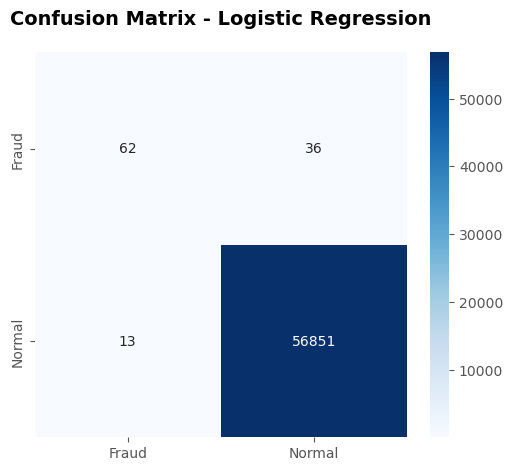

In [5]:
lr_model = LogisticRegression(random_state=42, max_iter=1000)
results_lr = train_model(
    model=lr_model,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    model_name="Logistic Regression",
    show_confusion_matrix=True
)

Данные результаты демонстрируют типичное поведение при работе с несбалансированными данными, где крайне важно анализировать такие метрики, как точность, полнота и F1-мера

- **Precision:** Показывает долю корректных положительных прогнозов. Рассчитывается как:

    $$
    \text{Precision} = \frac{TP}{TP + FP} = \frac{62}{62+10} = 0.8266
    $$

  где  $TP$ - это истинно-положительные случаи а $FP$ - ложно-положительные. Это означает, что 83% транзакций, классифицированных как мошеннические, действительно являлись таковыми.


- **Recall:** Показывает, какую долю реальных мошеннических операций модель смогла обнаружить. Рассчитывается как:

  $$
    \text{Recall} = \frac{TP}{TP + FN} = \frac{62}{62+36} = 0.6326
  $$

  где $FN$ ложно-отрицательные случаи. Модель обнаружила только 63% реальных мошеннических операций, оставив 37% невыявленными.
    
  В задаче обнаружения мошенничества полнота является более критичной метрикой, поскольку стоимость необнаруженного мошенничества (финансовые потери и репутационный ущерб) превышает стоимость ложной тревоги. Следовательно, необходимо максимизировать полноту, сохраняя приемлемую точность.


- **F1-Score:** Представляет собой гармоническое среднее между точностью и полнотой:

    $$
    \text{F1-Score} = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}} = 2\times \frac{0.8266 \times 0.6326}{0.8266 + 0.6326} = 0.72
    $$

- **Confusion matrix:** 56 851 нормальных транзакции были корректно идентифицированы, как и 62 мошеннических операции. Однако 36 случаев мошенничества были ошибочно классифицированы как нормальные (ложно-отрицательные)

    Хотя число 36 может показаться небольшим на фоне общего количества транзакций, оно является значительным, учитывая, что тестовая выборка содержала всего 98 случаев мошенничества (из 492 в исходном наборе данных). Это представляет собой 37% необнаруженных мошеннических операций - критически важную долю, имеющую серьезные финансовые последствия.



## ЛОГИСТИЧЕСКАЯ РЕГРЕССИЯ (с class_weight='balanced')

Используется модель логистической регрессии, но на этот раз с указанием параметра `class_weight='balanced'`. Это позволяет модели автоматически сбалансировать веса классов, обратно пропорционально их частотам в обучающих данных, что приводит к большей стоимости за ошибки в миноритарном классе. Формула, используемая для расчета весов, выглядит следующим образом:

$$
\text{weight}_i = \frac{n_{\text{total}}}{n_{\text{classes}} \times n_i}
$$

Где:

$n_{\text{total}}$ — общее количество наблюдений,

$n_{\text{classes}}$ — количество классов (в данном случае 2),

$n_i$ — количество наблюдений в классе $i$.

Это заставляет модель уделять больше внимания случаям мошенничества в процессе обучения, компенсируя дисбаланс классов и потенциально улучшая способность модели обнаруживать редкие, но важные мошеннические транзакции.

Logistic Regression with balanced

Classification Report:
              precision    recall  f1-score   support

       Fraud       0.06      0.92      0.11        98
      Normal       1.00      0.98      0.99     56864

    accuracy                           0.98     56962
   macro avg       0.53      0.95      0.55     56962
weighted avg       1.00      0.98      0.99     56962


ROC AUC Score: 0.9721
Precision: 0.0610
Recall: 0.9184
F1-Score: 0.1144
Training Time: 0.96s


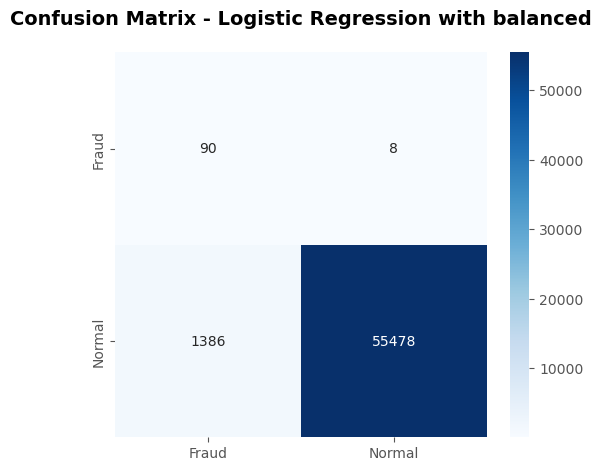

In [6]:
lr_balanced = LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000)
results_lr_balanced = train_model(
    model=lr_balanced,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    model_name="Logistic Regression with balanced",
    show_confusion_matrix=True
)

Данные результаты демонстрируют еще более выраженное поведение: меньше ложно-отрицательных результатов ценой увеличения ложноположительных срабатываний

- **Precision:** Составляет всего около 6.1%, генерируя 1 386 ложноположительных результатов (нормальные транзакции, ошибочно классифицированные как мошеннические). Это может привести к серьезным неудобствам для клиентов, необходимости проведения большого количества расследований и другим проблемам:

    $$
    \text{Precision} = \frac{TP}{TP + FP} = \frac{90}{90+1386} = 0.061
    $$

- **Recall:** Существенно возрастает до 92%, обнаруживая 90 из 98 реальных мошеннических транзакций. Это представляет собой улучшение на 29% по сравнению с несбалансированной логистической регрессией:

  $$
    \text{Recall} = \frac{TP}{TP + FN} = \frac{90}{90+8} = 0.9184
  $$

  С точки зрения минимизации потерь, только 8 случаев мошенничества (8%) остаются необнаруженными, что значительно снижает финансовые риски

- **F1-Score:** Представляет собой гармоническое среднее между точностью и полнотой:

    $$
    \text{F1-Score} = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}} = 2\times \frac{0.0609 \times 0.9183}{0.0609 + 0.9183} = 0.1144
    $$

- **Confusion matrix:** Модель корректно идентифицирует 55 478 нормальных транзакций и обнаруживает 90 из 98 реальных случаев мошенничества. Однако, после повышения Recall вызвало резкое падение Precision. Это значит, что наша модель логистической регрессии начала ошибочно помечать нормальные транзакций как мошенничество. Такая конфигурация модели может быть оправдана только в том случае, если цена пропуска мошеннической транзакции чрезвычайно высока, а затраты на расследование ложных срабатываний относительно невелики. Следует рассмотреть возможность использования других алгоритмов машинного обучения, которые лучше справляются с несбалансированными данными

## ЛОГИСТИЧЕСКАЯ РЕГРЕССИЯ (С UNDERSAMPLING)

Это метод балансировки данных, который решает проблему дисбаланса классов путем уменьшения количества образцов в преобладающем классе до соответствия количеству образцов в миноритарном классе

Эта процедура включает в себя разделение нормальных транзакций и мошеннических в обучающем наборе. Затем выбирается случайное подмножество нормальных транзакций, размер которого равен количеству мошеннических транзакций. В этом случае во всем наборе данных имеется 492 случая мошенничества, поэтому также случайным образом выбираются 492 нормальные транзакции. Наконец, мошеннические транзакции объединяются с этим уменьшенным подмножеством нормальных, создавая, таким образом, сбалансированный обучающий набор 50-50 для обучения модели логистической регрессии и позволяя ей изучать закономерности из обоих классов с равным весом.

Эта процедура снижает смещение, поскольку в исходном наборе данных количество нормальных транзакций значительно превышает количество мошеннических. Кроме того, полнота (recall) имеет тенденцию к улучшению при обучении на сбалансированных данных; однако важно отметить, что всегда будет компромисс с точностью (precision), которая имеет тенденцию к снижению по мере увеличения полноты.

In [7]:
def random_undersample(X, y, random_state=42):
    
    # Разделяем данные на мажоритарный (0) и миноритарный (1) классы
    X_majority = X[y == 0]
    X_minority = X[y == 1]
    y_majority = y[y == 0]
    y_minority = y[y == 1]
    

    np.random.seed(42)
    indices = np.random.choice(X_majority.index, size=len(X_minority), replace=False) # Выбираем случайные индексы из мажоритарного класса

    #Отбираеим признаки и целевую переменную для мажоритарного класса
    X_majority_undersampled = X_majority.loc[indices] 
    y_majority_undersampled = y_majority.loc[indices]
    
    # Объединяем undersampled мажоритарный класс с миноритарным классом
    X_balanced = pd.concat([X_majority_undersampled, X_minority])
    y_balanced = pd.concat([y_majority_undersampled, y_minority])
    
    return X_balanced, y_balanced

X_train_balanced, y_train_balanced = random_undersample(X_train, y_train)

Logistic Regression (Undersampled)

Classification Report:
              precision    recall  f1-score   support

       Fraud       0.04      0.92      0.07        98
      Normal       1.00      0.96      0.98     56864

    accuracy                           0.96     56962
   macro avg       0.52      0.94      0.53     56962
weighted avg       1.00      0.96      0.98     56962


ROC AUC Score: 0.9761
Precision: 0.0383
Recall: 0.9184
F1-Score: 0.0736
Training Time: 0.01s


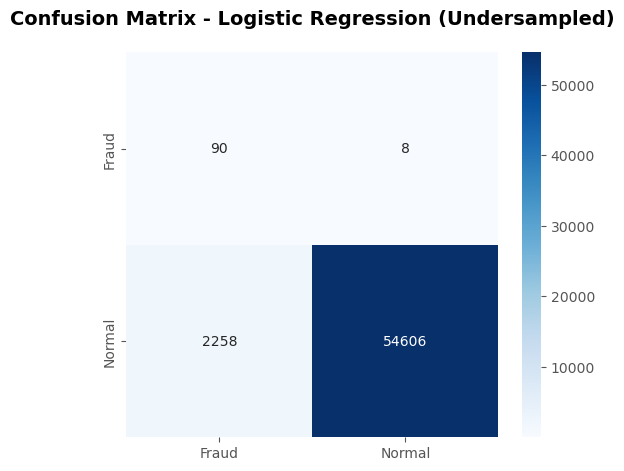

In [8]:
lr_undersampled = LogisticRegression(random_state=42, max_iter=1000)

results_lr_undersampled = train_model(
    model=lr_undersampled,
    X_train=X_train_balanced,
    y_train=y_train_balanced,
    X_test=X_test,
    y_test=y_test,
    model_name="Logistic Regression (Undersampled)",
    show_confusion_matrix=True
)

Модель логистической регрессии с Undersampling, схожа с сбалансированной, но в более выраженной форме: приоритет отдается обнаружению мошенничества, но при этом генерируется значительное количество ложных срабатываний. 

- **Precision:** Всего 4%
    $$
    \text{Precision} = \frac{TP}{TP + FP} = \frac{90}{90+2258} = 0.383
    $$

- **Recall:** Остается такой же, как у сбалансированной - 92%

  $$
    \text{Recall} = \frac{TP}{TP + FN} = \frac{90}{90+8} = 0.9184
  $$

  С точки зрения минимизации потерь, только 8 случаев мошенничества (8%) остаются необнаруженными, что значительно снижает финансовые риски

- **F1-Score:** Из-за точности упал до 7%:

    $$
    \text{F1-Score} = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}} = 2\times \frac{0.384 \times 0.9183}{0.384 + 0.9183} = 0.0736
    $$

  undersampling, хотя и эффективен для улучшения полноты, чрезмерно сместил порог принятия решения, делая модель слишком консервативной при классификации мошенничество

- **Confusion matrix:** Модель корректно идентифицирует 55 606 нормальных транзакций и обнаруживает 90 из 98 реальных случаев мошенничества, оставляя необнаруженными только 8. Но, количество сгенерированных ложных срабатываний оставляет желать лучшего

Проблема в том, что для обучения модель использовали сильно урезанный набор данных, где мошеннических и обычных транзакций было поровну. В реальной жизни мошеннических транзакций очень мало, поэтому модель просто забыла, как выглядят настоящие, нормальные транзакции и начала подозревать все подряд.

В итоге, модель стала слишком чувствительной и генерирует слишком много ложных срабатываний, что делает ее бесполезной для практического применения. 

## СЛУЧАЙНЫЙ ЛЕС (RANDOM FOREST)

Это метод коллективного обучения, который строит множество деревьев решений. Каждое дерево обучается на случайном подмножестве данных и признаков (bagging). При каждом разбиении каждого дерева учитывается только случайное подмножество признаков, что вносит дополнительное разнообразие в деревья и уменьшает корреляцию, которая может существовать между ними. Прогноз делается путем голосования, когда каждое дерево в случайном лесе отдает свой голос за предсказанный класс, и класс, набравший наибольшее количество голосов, выбирается в качестве окончательного прогноза модели

Random Forest

Classification Report:
              precision    recall  f1-score   support

       Fraud       0.94      0.82      0.87        98
      Normal       1.00      1.00      1.00     56864

    accuracy                           1.00     56962
   macro avg       0.97      0.91      0.94     56962
weighted avg       1.00      1.00      1.00     56962


ROC AUC Score: 0.9630
Precision: 0.9412
Recall: 0.8163
F1-Score: 0.8743
Training Time: 57.25s


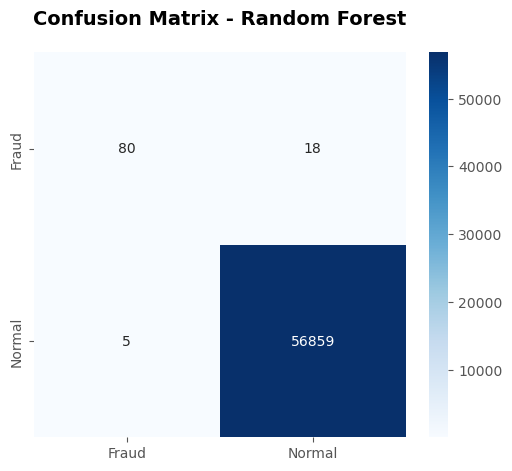

In [9]:
rf_default = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

results_rf_default = train_model(
    model=rf_default,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    model_name="Random Forest",
    show_confusion_matrix=True
)

## ДЕРЕВЬЯ РЕШЕНИЙ (BAGGING/DECISION TREES)

DECISION TREES

Classification Report:
              precision    recall  f1-score   support

       Fraud       0.87      0.84      0.85        98
      Normal       1.00      1.00      1.00     56864

    accuracy                           1.00     56962
   macro avg       0.94      0.92      0.93     56962
weighted avg       1.00      1.00      1.00     56962


ROC AUC Score: 0.9740
Precision: 0.8723
Recall: 0.8367
F1-Score: 0.8542
Training Time: 246.10s


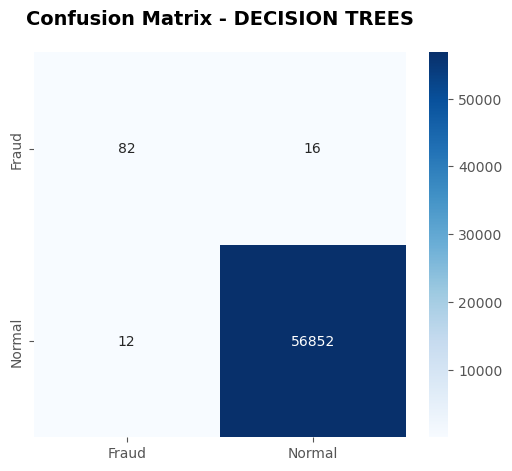

In [10]:
bagging = BaggingClassifier(
    estimator=DecisionTreeClassifier(
        max_depth=10, 
        min_samples_split=20,
        min_samples_leaf=10,
    ),
    n_estimators=100,
    random_state=42,
    n_jobs=-1,
)

results_bagging = train_model(
    model=bagging,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    model_name="DECISION TREES",
    show_confusion_matrix=True,
)

## ГРАДИЕНТНЫЙ БУСТИНГ (XGBOOST)

XGBoost

Classification Report:
              precision    recall  f1-score   support

       Fraud       0.88      0.84      0.86        98
      Normal       1.00      1.00      1.00     56864

    accuracy                           1.00     56962
   macro avg       0.94      0.92      0.93     56962
weighted avg       1.00      1.00      1.00     56962


ROC AUC Score: 0.9684
Precision: 0.8817
Recall: 0.8367
F1-Score: 0.8586
Training Time: 2.76s


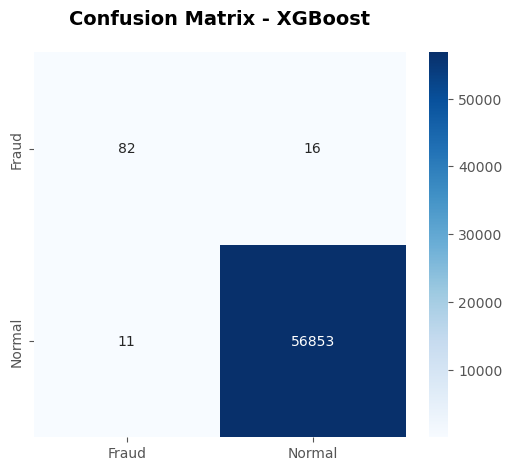

In [11]:
xgboost = XGBClassifier(
    scale_pos_weight=len(y_train[y_train == 0]) / len(y_train[y_train == 1]),
    max_depth=6,
    learning_rate=0.1,
    n_estimators=200,
    random_state=42,
    n_jobs=-1,
    eval_metric='logloss'
)

results_xgboost = train_model(
    model=xgboost,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    model_name="XGBoost",
    show_confusion_matrix=True
)